# Homework 4

İrem Demir, 69563

## Mysql-Python Connection

In [1]:
import mysql.connector
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import csv

%matplotlib inline

In [2]:
db_connection = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="root", # change password
  auth_plugin='mysql_native_password'
)
print(db_connection)

In [3]:
# creating database_cursor to perform SQL operation to run queries
db_cursor = db_connection.cursor(buffered=True)

# executing cursor with execute method and pass SQL query
#db_cursor.execute("CREATE DATABASE hw4")

# get list of all databases
db_cursor.execute("SHOW DATABASES")

# print all databases
for db in db_cursor:
    print(db)
    
db_cursor.execute("USE hw4")

('fullstackfirst',)
('hw4',)
('information_schema',)
('mysql',)
('performance_schema',)
('ps_ecommerce',)
('sys',)
('world',)


## Load Data to Mysql Tables

In [4]:
def populate_table(db_connection, db_cursor, insert_query, file_path):
    
    with open(file_path, mode='r') as csv_data:
        reader = csv.reader(csv_data, delimiter=';')
        csv_data_list = list(reader)
        for row in csv_data_list[1:]:
            row = tuple(map(lambda x: None if x == "" else x, row[0].split(',')))
            db_cursor.execute(insert_query, row)
        
    db_connection.commit()

In [ ]:
# create CUSTOMERS table
db_cursor.execute("""CREATE TABLE CUSTOMERS (customer_id VARCHAR(50) NOT NULL, 
                                          customer_unique_id VARCHAR(50) NOT NULL, 
                                          customer_zip_code_prefix VARCHAR(50), 
                                          customer_city VARCHAR(50), 
                                          customer_state VARCHAR(50))""")

insert_customers = (
    "INSERT INTO CUSTOMERS(customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_customers, "data/customers.csv")

In [ ]:
# create ORDER_PAYMENTS table
db_cursor.execute("""CREATE TABLE ORDER_PAYMENTS (order_id VARCHAR(50) NOT NULL, 
                                          payment_sequential INTEGER, 
                                          payment_type VARCHAR(50), 
                                          payment_installments INTEGER, 
                                          payment_value FLOAT)""")

insert_orderpayments = (
    "INSERT INTO ORDER_PAYMENTS(order_id, payment_sequential, payment_type, payment_installments, payment_value) "
    "VALUES (%s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderpayments, "data/order_payments.csv")

In [ ]:
# create ORDER_ITEMS table
db_cursor.execute("""CREATE TABLE ORDER_ITEMS (order_id VARCHAR(50) NOT NULL, 
                                          order_item_id INTEGER, 
                                          product_id VARCHAR(50), 
                                          seller_id VARCHAR(50), 
                                          shipping_limit_date DATETIME,
                                          price FLOAT,
                                          freight_value FLOAT)""")

insert_orderitems = (
    "INSERT INTO ORDER_ITEMS(order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orderitems, "data/order_items.csv")

In [ ]:
# create ORDERS table
db_cursor.execute("""CREATE TABLE ORDERS (order_id VARCHAR(50) NOT NULL, 
                                          customer_id VARCHAR(50) NOT NULL, 
                                          order_status VARCHAR(50), 
                                          order_purchase_timestamp DATETIME, 
                                          order_approved_at DATETIME,
                                          order_delivered_carrier_date DATETIME,
                                          order_delivered_customer_date DATETIME,
                                          order_estimated_delivery_date DATETIME)""")

insert_orders = (
    "INSERT INTO ORDERS(order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_orders, "data/orders.csv")

## Question 1 (10 pts)

In [ ]:
# Find the average number of weeks between products' actual delivery dates and estimated delivery dates. 
# Use order_delivered_customer_date column as actual delivery dates and 
# order_estimated_delivery_date column as estimated delivery dates.

# HINT: There is a function in MySQL that makes it easy to compute the difference between two timestamps.
# We recommend that you search for it online and use it in your answer.

Reference : https://dev.mysql.com/doc/refman/5.7/en/date-and-time-functions.html#function_timestampdiff

In [5]:
# Solve Question 1 below
#I took absolute value since I want to have difference no matter it is delivered earlier or late
avg_weeks_diff_query = """SELECT AVG(ABS(TIMESTAMPDIFF(week,order_delivered_customer_date, order_estimated_delivery_date))) 
                            FROM ORDERS"""
db_cursor.execute(avg_weeks_diff_query)
avg_weeks_diff_result = db_cursor.fetchall()
avg_weeks_diff_result[0]

(Decimal('1.3386'),)

## Question 2 (15 pts)

In [ ]:
# Consider the ORDER_COSTS table below. 
# Using this table and the CUSTOMERS table, find the following:
# In which states do customers spend, on average, more than 164 on their orders? 
# Fetch those states and average order costs in those states. 
#Results should be ordered from lowest cost to highest.

In [ ]:
order_costs_query = """
                    CREATE TABLE ORDER_COSTS AS (
                        SELECT ORDERS.order_id, SUM(price) AS cost, ORDERS.customer_id as cid
                        FROM ORDER_ITEMS 
                             JOIN ORDERS
                             ON ORDER_ITEMS.order_id=ORDERS.order_id
                        GROUP BY order_id, ORDERS.customer_id)
                    """

db_cursor.execute(order_costs_query)

In [7]:
# Solve Question 2 below
order_cost_state_query =  """
                    select customer_state, avg(cost) as average_cost
                    from order_costs oc
                    join customers  c on c.customer_id = oc.cid
                    group by c.customer_state
                    having average_cost >164
                    order by average_cost
                    """
db_cursor.execute(order_cost_state_query)
order_cost_state_result = db_cursor.fetchall()
order_cost_state_result

[('PE', 165.95715586927687),
 ('RN', 168.72618171229507),
 ('MS', 173.50979253761005),
 ('TO', 179.9429249493581),
 ('PA', 182.85564198849806),
 ('MT', 184.82068734097837),
 ('AL', 202.31006200565315),
 ('RO', 217.85388387291178),
 ('PB', 222.1680950891404),
 ('AC', 224.56719970703125),
 ('RR', 279.38705960442036)]

## Question 3 (15 pts)

In [ ]:
# Implement the following function get_month. It takes as input a month as an integer.
# It needs to compute: In the given month, how many payments were made with each different payment type?
# e.g.: Credit card -> 5000 payments, debit card -> 100 payments, voucher -> 300 payments, ...

# HINT: One of the MySQL functions we covered in the PS makes it easy to work with months.

In [8]:
# Solve Question 3 below

def get_month(month):
    
    query = "select payment_type, count(payment_type) from order_payments op join orders o on o.order_id = op.order_id where month(o.order_purchase_timestamp) =" + month + " group by op.payment_type"
    db_cursor.execute(query)
    items = db_cursor.fetchall()
    return items

In [9]:
# Here is a sample function call for get_month:
print(get_month("2"))

[('credit_card', 6609), ('boleto', 1723), ('voucher', 424), ('debit_card', 82)]


## Question 4 (10 pts)

In [ ]:
# Consider the PRODUCTS table below and the ORDER_ITEMS table from earlier. 
# For each product category other than {"moveis_decoracao", "beleza_saude"}, find the minimum price that was paid for
# an item from that category. Limit the result to retrieve only 6 rows.

# The result should be like: category1 -> minprice1, category2 -> minprice2, ...

In [ ]:
db_cursor.execute("""CREATE TABLE PRODUCTS (product_id VARCHAR(50) NOT NULL, 
                                            product_category_name VARCHAR(50), 
                                            product_name_lenght INTEGER, 
                                            product_description_lenght INTEGER, 
                                            product_photos_qty INTEGER,
                                            product_weight_g INTEGER,
                                            product_length_cm INTEGER,
                                            product_height_cm INTEGER,
                                            product_width_cm INTEGER)""")

insert_products = (
    "INSERT INTO PRODUCTS(product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm,  product_height_cm, product_width_cm) "
    "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
)

populate_table(db_connection, db_cursor, insert_products, "data/products.csv")

In [10]:
# Solve Question 4 below
product_category_query = """select product_category_name, min(price)
                            from products
                            join order_items on order_items.product_id = products.product_id
                            group by product_category_name
                            having product_category_name != "moveis_decoracao" and 
                            product_category_name != "beleza_saude"
                            limit 6;"""
db_cursor.execute(product_category_query)
product_category_result = db_cursor.fetchall()
product_category_result


[('esporte_lazer', 5.49),
 ('utilidades_domesticas', 4.4),
 ('cama_mesa_banho', 6.99),
 ('informatica_acessorios', 3.9),
 ('relogios_presentes', 8.99),
 ('brinquedos', 4.99)]

## Question 5 (10 pts)

In [ ]:
# Draw a pie chart using the data from the previous question.
# Labels of your pie chart should be the product categories.
# Contents of your pie chart (i.e., sizes of the pie slices) should be determined by the min prices.

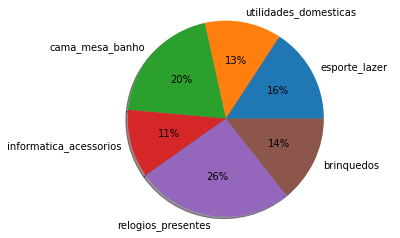

In [11]:
# Solve Question 5 below
product_category, min_price = map(list, zip(*product_category_result))
fig1, ax1 = plt.subplots()
ax1.pie(min_price, labels=product_category, autopct='%1.0f%%', shadow=True)
ax1.axis('equal') 
plt.show()

## Question 6 (15 pts)

In [ ]:
# Let us define "large products" as those products with weight > 400 and length > 10.
# Some orders that contain a large product can have large discrepancies between their order_delivered_carrier_date and 
# order_delivered_customer_date. 
# Let us define "strange orders that contain large products" as those orders which contain a large product and the 
# difference between their order_delivered_carrier_date and order_delivered_customer_date is larger than 100 days.

# For all "strange orders that contain large products", find their order IDs and the number of days difference between 
# their order_delivered_carrier_date and order_delivered_customer_date.
# Result should be like: "abc21312df" -> 32, "dhs230kdf8" -> 29, ...

# HINT: Using the same MySQL function as Question 1 may help.

In [13]:
# Solve Question 6 below
strange_orders_query ="""select distinct o.order_id , abs(timestampdiff(day, order_delivered_customer_date, order_delivered_carrier_date))
                        from orders o 
                        join order_items oi on o.order_id = oi.order_id
                        join products p on oi.product_id = p.product_id
                        where p.product_weight_g >400 and p.product_length_cm > 10  
                        and abs(timestampdiff(day, order_delivered_customer_date, order_delivered_carrier_date)) > 100
                        order by o.order_id;""" 

db_cursor.execute(strange_orders_query)
strange_orders_result = db_cursor.fetchall()
strange_orders_result


[('031e7d4e559a1bf08e71a419aa998d0a', 165),
 ('0b32bf55276b5feb681f6ed6fd670692', 143),
 ('0f4519c5f1c541ddec9f21b3bddd533a', 181),
 ('160d1364f477494647a995f6bbec0b5f', 104),
 ('1b3190b2dfa9d789e1f14c05b647a14a', 205),
 ('2ba1366baecad3c3536f27546d129017', 178),
 ('3b919fbc512d96f81330d2aae3ed0cf6', 106),
 ('437222e3fd1b07396f1d9ba8c15fba59', 182),
 ('47b40429ed8cce3aee9199792275433f', 157),
 ('525e11b26fdb7f41471d289897d0f6da', 167),
 ('6e3a1f3ec46461756c3f620e267aa1b8', 103),
 ('6e82dcfb5eada6283dba34f164e636f5', 180),
 ('7e708aed151d6a8601ce8f2eaa712bf4', 134),
 ('a4efaffc506a395c9cea7402b078c1e5', 103),
 ('cce224811ba8fea016c049693c3e0402', 145),
 ('d24e8541128cea179a11a65176e0a96f', 171),
 ('d8dbb44d7c5b1fd8e7f41b49e27053d7', 104),
 ('dfe5f68118c2576143240b8d78e5940a', 181),
 ('e52c9dfec957c503bed5d050a39c740f', 102)]

## Question 7 (10 pts)

In [ ]:
# Draw a bar chart using the data from the previous question.
# Order IDs should be on the x-axis.
# Number of days difference should be on the y-axis.
# (Although we are not looking for production quality figures, make sure that your plots are readable.)

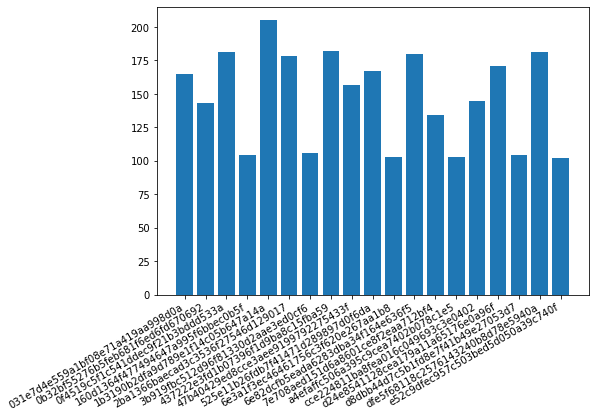

In [14]:
# Solve Question 7 below
order_id, days = map(list, zip(*strange_orders_result))
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ax2.bar(order_id, days)
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## Question 8 (15 pts)

In [ ]:
# Write an SQL query to find the total number of orders per week day, e.g., Monday -> 150 orders, Tuesday -> 200 orders,
# Wednesday -> 500 orders, etc. Use the "order_purchase_timestamp" attribute when counting the number of orders.
# Plot the result using a bar chart (days of week on x-axis, number of orders on y-axis). 

# HINT: Check out the "WEEKDAY" function of MySQL. 

Reference: https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_dayname

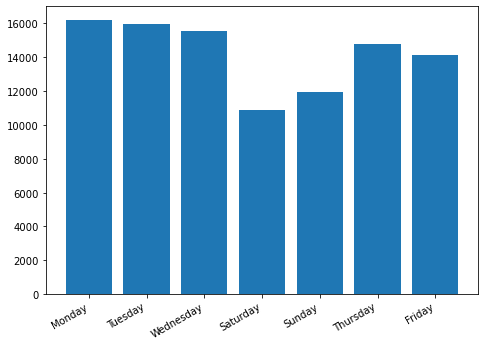

In [15]:
# Solve Question 8 below
week_day_order_query = """select dayname(order_purchase_timestamp) as week_day,count(*)
                        from orders
                        group by week_day"""
db_cursor.execute(week_day_order_query)
week_day_order_result = db_cursor.fetchall()

week_day, order_count = map(list, zip(*week_day_order_result))
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,1,1])
ax3.bar(week_day, order_count)
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()


In [16]:
db_cursor.close()
db_connection.close()